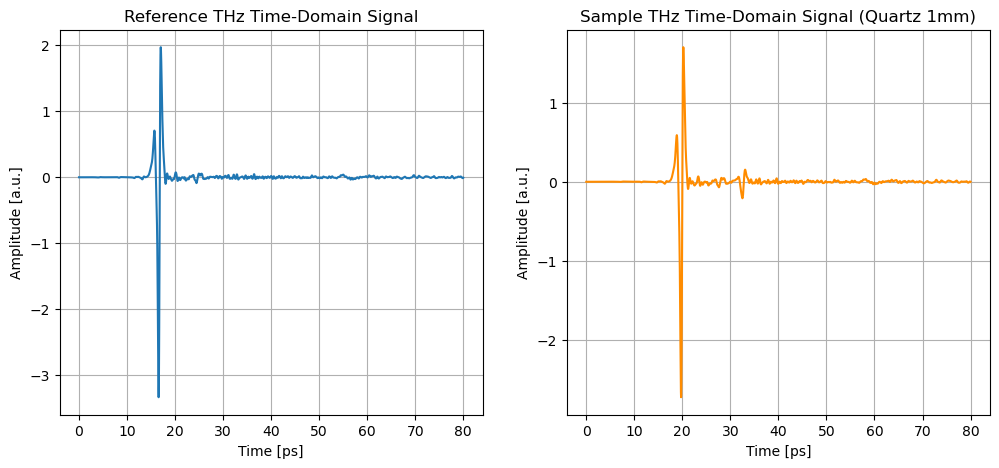

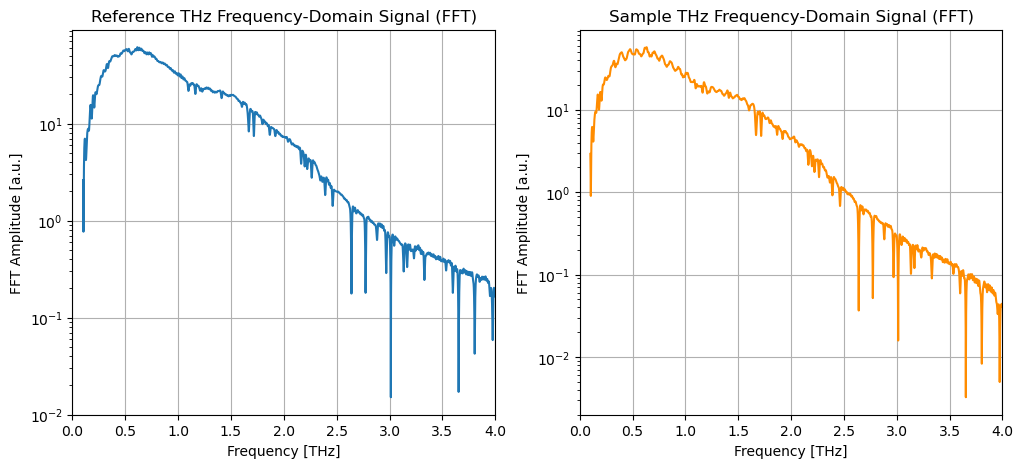

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import signal


# INSERT REFERENCE DATA 
reference_pulse = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_06_02_2026\reference_15min_2nd_run_nitrogen.txt",dtype=float)

# INSERT SAMPLE DATA
sample_pulse_Quartz = np.loadtxt(r"C:\miniconda_projects\repository\TerahertzProject\TheoTHzTDS\THz-TDS\Transfer Matrix Method\data_06_02_2026\Quartz_1mm_15min_nitrogen.txt",dtype=float)

t1= reference_pulse[:,0] + 740  # ADJUISTING THE AXIS
amp1 = reference_pulse[:,1]
t2 = sample_pulse_Quartz[:,0] + 740  # ADJUISTING THE AXIS
amp2 = sample_pulse_Quartz[:,1]


# FFT OF SIGNALS
reference_fft = np.fft.fft(amp1,65536)
sample_fft = np.fft.fft(amp2,65536)

time_step = t1[1] - t1[0]
frequency = np.fft.fftfreq(65536, d=time_step*1e-12)  # Convert ps to s for frequency calculation

# MASK
mask = (frequency > 0.1 * 10**12) & (frequency < 4 * 10**12)
reference_fft = reference_fft[mask]
sample_fft = sample_fft[mask]
frequency = frequency[mask]

# PLOTTING REFERENCE AND SAMPLE SIGNALS


# PLOTS
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(t1,amp1)
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Reference THz Time-Domain Signal')
plt.grid()  
plt.subplot(1,2,2)
plt.plot(t2,amp2, color='darkorange')
plt.xlabel('Time [ps]')
plt.ylabel('Amplitude [a.u.]')
plt.title('Sample THz Time-Domain Signal (Quartz 1mm)')
plt.grid()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(frequency*1e-12,np.abs(reference_fft))
plt.xlim(0,4)
plt.yscale('log')
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Reference THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.subplot(1,2,2)
plt.plot(frequency*1e-12,np.abs(sample_fft), color='darkorange')
plt.xlim(0,4)
plt.yscale('log')
plt.xlabel('Frequency [THz]')
plt.ylabel('FFT Amplitude [a.u.]')
plt.title('Sample THz Frequency-Domain Signal (FFT)')
plt.grid()
plt.show()


Time delay (ps):  3.1683168299999807


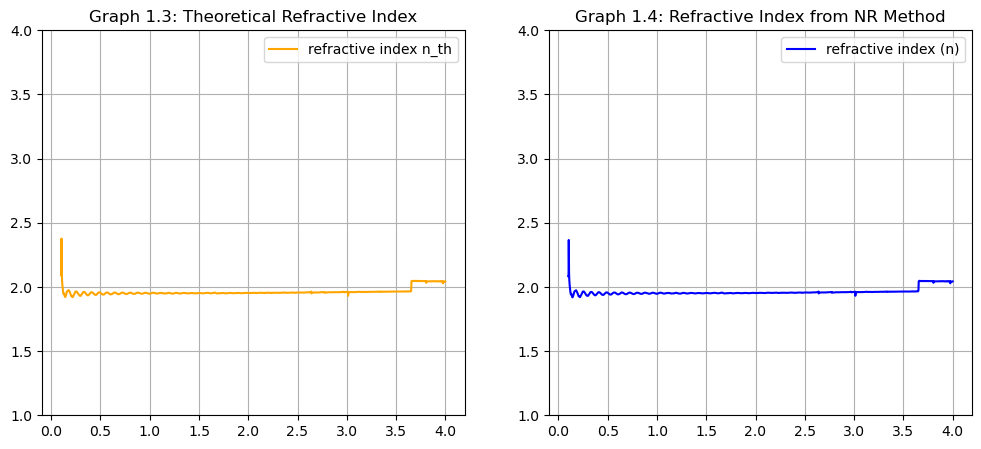

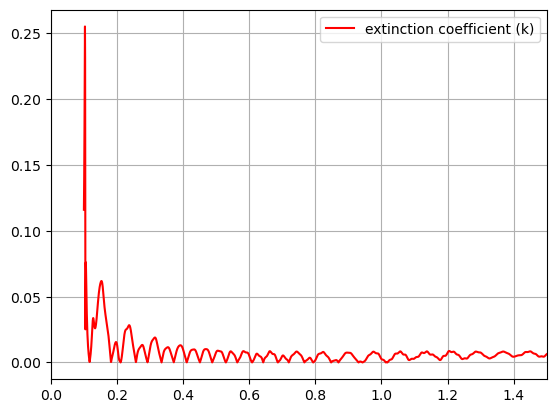

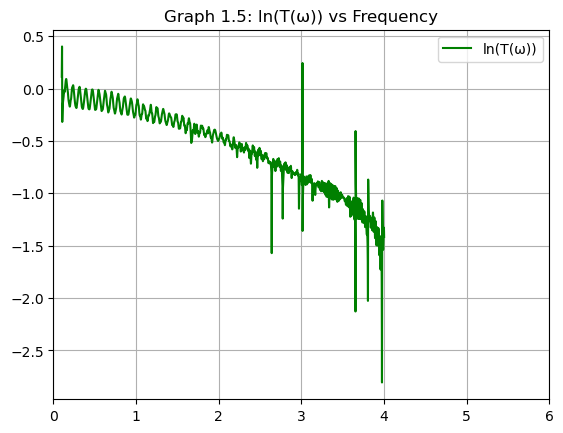

The average refractive index (n) is: 1.962941602155202
The average extinction coefficient (k) is: -0.007186091907556651


In [8]:
# PHASE UNWRAPPING 
uwrapped_ref = np.unwrap(np.angle(reference_fft))
uwrapped_sample = np.unwrap(np.angle(sample_fft))
delta = uwrapped_sample - uwrapped_ref 


# TIME DELAY BETWEEN SIGNALS CALCULATION

max_reference_signal = np.max(amp1)
point_in_time_ref = t1[amp1.argmax()]
max_sample_signal = np.max(amp2)
point_in_time_sample = t2[amp2.argmax()]

dt = np.abs(  (point_in_time_sample) -  (point_in_time_ref) ) #time delay in ps
print("Time delay (ps): ", dt)


# REFRACTIVE INDEX CALCULATION

frequency[frequency == 0] = 1e-12  # Replace zeros with a small value to avoid division by zero
c = 3e8 #speed of light in m/s
d = 1e-3 #thickness of sample in m
n_0 = 1  # Refractive index of air



# TRANSFER FUNCTION CALCULATION

transfer_signal = sample_fft / reference_fft
transfer_phase = np.angle(transfer_signal)
tphase_unwrapped = np.unwrap(transfer_phase)
#tphase_unwrapped -= tphase_unwrapped[0]-0.5*np.pi
ln_transfer = np.log(np.abs(transfer_signal) + 1e-12) + 1j * tphase_unwrapped


refractive = 1 + (np.abs(delta)* c) / (2 * np.pi * frequency * d)

# NEWTON RAPHSON METHOD
def G_zero(n, f, ln_exp):

    ln_th =(np.log((4 * n_0 * n) / (n_0 + n)**2)
             -(1j * 2 * np.pi * f * d / c) * (n - n_0))
    return  ln_th - ln_exp

def G_zerod(n, f):
    p = 1 / n
    m = 2 / (n + n_0) + (1j * 2 * np.pi* f * d) / c 
    return p - m 

def new_raph(n_1, ln_exp, f, iterations, tol):
    n = n_1
    for i in range(iterations): 
        G_zero_ = G_zero(n,  f, ln_exp)
        G_zerod_ = G_zerod(n, f)
        dn = G_zero_ / G_zerod_
        n = n - dn
        if abs(G_zero_/G_zerod_) < tol:
           # print(i, "iterations")
            break
    return n


# INITIAL GUESS AND CALCULATION
n_1 = 2 + 0.05j
n_ = []

for i, f in enumerate(frequency, 0):
    ln_exp = np.log(np.abs(transfer_signal[i])) + 1j * tphase_unwrapped[i]
    n_values = new_raph( n_1 ,ln_exp, f,  iterations=50, tol=1e-10)
    n_.append(n_values)


# print("Refractive index values:", n_)
n_ = np.array(n_) 


# PLOTTING REFRACTIVE INDEX AND TRANSFER FUNCTION

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(frequency*1e-12, refractive, label='Refractive Index [theoretical]', color='orange')
#plt.xlim(xmax = 3.5, xmin = 0)
plt.ylim(ymin=1, ymax=4)
plt.legend(["refractive index n_th"])
plt.grid(True)
plt.title('Graph 1.3: Theoretical Refractive Index')
plt.subplot(1,2,2)
plt.plot(frequency*1e-12, n_.real, label='Refractive Index [n]', color='blue')
#plt.xlim(xmax = 3.5, xmin = 0)
plt.ylim(ymin=1, ymax=4)
plt.legend(["refractive index (n)"])
plt.grid(True)
plt.title('Graph 1.4: Refractive Index from NR Method')
plt.show()


plt.plot(frequency*1e-12, np.abs(n_.imag), label='Extinction Coefficient (k)', color='red')
plt.xlim(xmax = 1.5, xmin = 0)
#plt.ylim(ymin=0,ymax=2)
plt.legend(["extinction coefficient (k)"])
plt.grid(True)
plt.show()

plt.plot(frequency*1e-12, np.log(np.abs(transfer_signal)), label='Transfer Function Amplitude', color='green')
plt.xlim(xmax = 6, xmin = 0)
plt.legend(["ln(T(ω))"])
plt.title('Graph 1.5: ln(T(ω)) vs Frequency')
plt.grid(True)
plt.show()  


print(f"The average refractive index (n) is: {np.mean(n_.real)}")
print(f"The average extinction coefficient (k) is: {np.mean(n_.imag)}")   


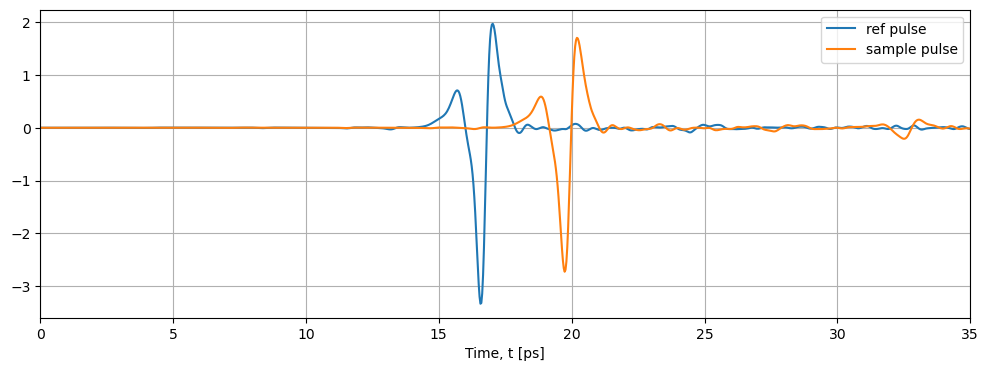

In [3]:
import torch
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor
from Matrix_methods.Simulate import simulate_parallel

# BAYES AND ADAM EXTRACTION

# CONVERT DATA TO TENSORS

# REFERENCE PULSE
reference_pulse_tensor = torch.tensor(amp1, dtype=torch.float32)
#SAMPLE PULSE
sample_pulse_tensor = torch.tensor(amp2, dtype=torch.float32)


plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(),label='ref pulse')
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),label='sample pulse')
plt.xlabel('Time, t [ps]')
plt.legend()
plt.xlim(0,35)
plt.grid()
plt.show()

Delta t:  3.30033000000185e-14
Number of time points, L:  2425
Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (1.662, 2.262)
Layer 1 - k ∈ (-0.008, -0.006)
Layer 1 - D ∈ (0.00098, 0.00102)
[((1.9688345323603964-0.006j), 0.00098)]


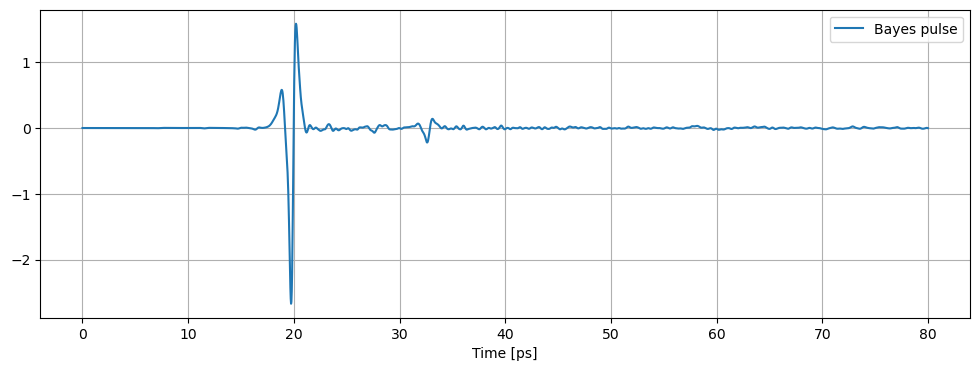

Fine-tuning 3 parameters for 2000 iterations.
Iteration 49, Loss: 1.170006e-02, Layer 0: n=1.9735, k=-0.00398, D=975.39 µm
Iteration 99, Loss: 1.104707e-02, Layer 0: n=1.9775, k=-0.00395, D=971.61 µm
Iteration 149, Loss: 1.082109e-02, Layer 0: n=1.9800, k=-0.00393, D=969.17 µm
Iteration 199, Loss: 1.077071e-02, Layer 0: n=1.9814, k=-0.00392, D=967.93 µm
Iteration 249, Loss: 1.076343e-02, Layer 0: n=1.9819, k=-0.00392, D=967.42 µm
Iteration 299, Loss: 1.076274e-02, Layer 0: n=1.9821, k=-0.00392, D=967.25 µm
Iteration 349, Loss: 1.076270e-02, Layer 0: n=1.9821, k=-0.00392, D=967.21 µm
Iteration 399, Loss: 1.076270e-02, Layer 0: n=1.9822, k=-0.00392, D=967.20 µm
Iteration 449, Loss: 1.076269e-02, Layer 0: n=1.9822, k=-0.00392, D=967.20 µm
Iteration 499, Loss: 1.076270e-02, Layer 0: n=1.9822, k=-0.00392, D=967.20 µm
Iteration 549, Loss: 1.076270e-02, Layer 0: n=1.9822, k=-0.00392, D=967.20 µm
Iteration 599, Loss: 1.076270e-02, Layer 0: n=1.9822, k=-0.00392, D=967.20 µm
Iteration 649, Loss:

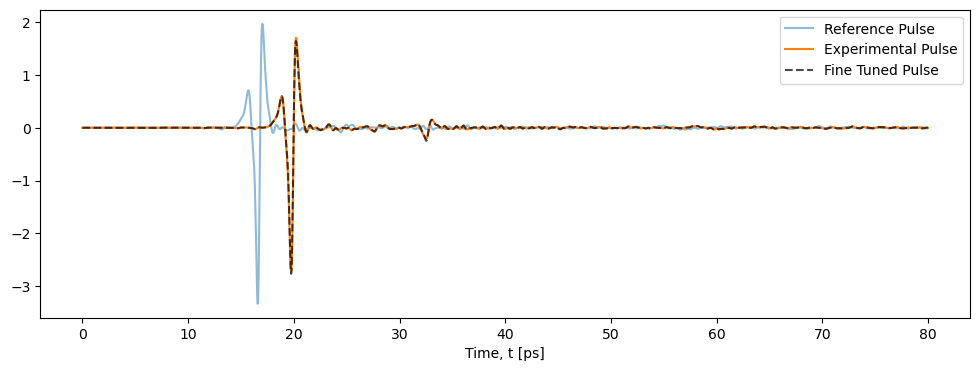

In [12]:
# set initial guesses for Bayes optimization
layers_init = [(1.962-0.007j, 1e-3)] 
# set bounds for optimization
optimization_bounds = [0.3, 0.001, 0.20e-4]

deltat = t1[1] - t1[0]
deltat = deltat * 1e-12
L = len(reference_pulse)


print("Delta t: ", deltat)
print("Number of time points, L: ", L)

# Set optimization mask
optimization_mask = [(True, True, True),]


# Initialize extractor for the data
Bayes_extractor = BayesianLayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, layers_init,optimization_bounds=optimization_bounds,optimize_mask=optimization_mask)

# Run the extraction loop and returns parameters
bayes_params = ms = Bayes_extractor.bayesian_optimization(n_calls=50)




# Run forward pass with Jeff’s model
bayes_pulse = simulate_parallel(reference_pulse_tensor,bayes_params, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

 # Print the parameters
print(bayes_params)

 # plot the pulse
plt.figure(figsize=(12,4))
plt.plot(t1, bayes_pulse, label='Bayes pulse', linestyle='-')
plt.xlabel('Time [ps]')
plt.grid(True)
plt.legend()
plt.show()







 # Initialize adam optimizer object
grad_optimizer = LayeredExtractor(reference_pulse_tensor,sample_pulse_tensor, deltat, bayes_params,optimization_mask, lr=0.0001)
 # Run optimization for set iterations, ‘updates’ provides a printout of progress
optim_params = grad_optimizer.optimize(num_iterations=2000,updates=50)
optim_pulse = simulate_parallel(reference_pulse_tensor,
optim_params, deltat, 0)[1].detach().cpu().numpy()[:L]
print(optim_params)
plt.figure(figsize=(12,4))
plt.plot(t1, reference_pulse_tensor.detach().cpu().numpy(), label='Reference Pulse',
alpha=0.5)
plt.plot(t2, sample_pulse_tensor.detach().cpu().numpy(),
label='Experimental Pulse')
plt.plot(t1, optim_pulse, label='Fine Tuned Pulse',alpha=0.7, linestyle='--',color='black')
plt.xlabel('Time, t [ps]')
plt.legend() 
plt.show()

In [13]:
optim_params

[((1.9821382761001587-0.003920873161405325j), 0.0009672132437117398)]

Text(0.5, 1.0, 'Graph 1.7: Adam Optimization Loss History')

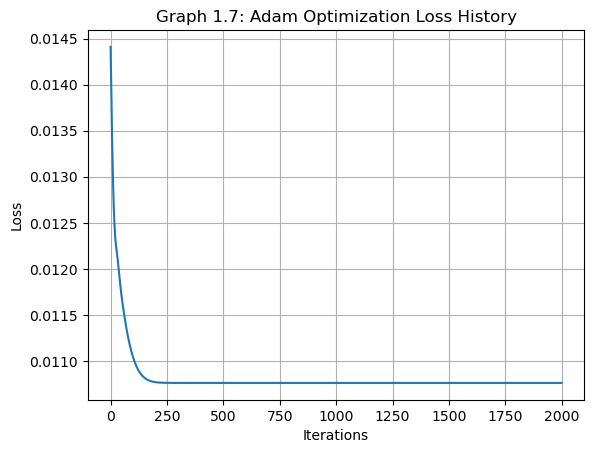

In [17]:
plt.plot(grad_optimizer.loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.grid(True)
plt.title('Graph 1.7: Adam Optimization Loss History')